In [1]:
from model_plus import NewNet
from PIL import Image
import torch
from torchvision.transforms import Compose, Grayscale, ToTensor
import matplotlib.pyplot as plt
import cv2
import numpy as np

%matplotlib inline

**载入模型,读取X,使用模型,得到ED(X)**

In [2]:
THRESHOLD_VALUE = 0.0045
class_number = "Class1"

In [3]:
# 指定模型
model = NewNet()

# 载入模型
model.load_state_dict(torch.load(f'./model/NewNet_model_{class_number}.pt'))

# 使模型进入测试模式
model.eval()

# 指定使用GPU
model = model.to('cuda')

# 图片路径
imgpath = f"./image/{class_number}/img2.PNG"

# 以灰度图读取图片
img = Image.open(imgpath).convert('L')

# 定义数据预处理操作：将图像转化为灰度图像，将其转化为tensor格式
transform = Compose([Grayscale(), ToTensor()])

# 使用预处理的方式读取图片
img = transform(img)

# 以GPU的方式运行

img = img.to('cuda')

# 对数据0维度进行扩充
img = img.unsqueeze(0)

# 模型输出结果为y
y = model(img)

# 进行相减，结果保留绝对值
S = torch.abs(img[0][0]-y[0][0])

shape=(512, 512)
max=0.9882352948188782
min=0.0
mean=0.2956653833389282


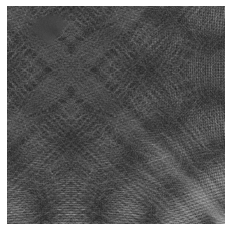

In [4]:
# 1.原图像
x = img.detach().cpu().numpy()[0][0]
plt.axis('off')
# plt.title("x")
plt.imshow(x,cmap=plt.cm.gray)

target = x
print(f'shape={target.shape}\nmax={target.max()}\nmin={target.min()}\nmean={target.mean()}')

shape=(512, 512)
max=0.964680552482605
min=0.0009812865173444152
mean=0.2943757474422455


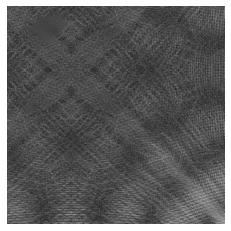

In [5]:
# EDx
EDx = y[0][0].detach().cpu().numpy()
plt.axis('off')
# plt.title("ED(x)")
plt.imshow(EDx,cmap=plt.cm.gray)

target = EDx
print(f'shape={target.shape}\nmax={target.max()}\nmin={target.min()}\nmean={target.mean()}')

shape=(512, 512)
max=0.06117522716522217
min=0.0
mean=0.0027165699284523726


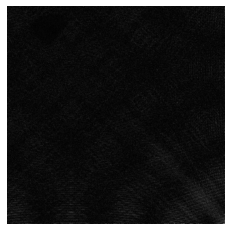

In [6]:
# 计算x-EDx
s_EDX = S.detach().cpu().numpy()

plt.axis('off')
# plt.title("FD")
plt.imshow(s_EDX,cmap=plt.cm.gray)

target = s_EDX
print(f'shape={target.shape}\nmax={target.max()}\nmin={target.min()}\nmean={target.mean()}')

shape=(512, 512)
max=255.0
min=0.0
mean=45.03530502319336


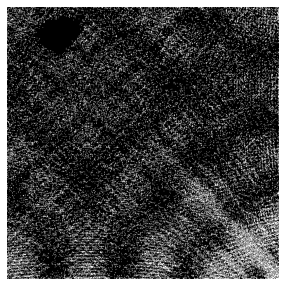

In [7]:
# 4:THRESHOLD操作
# THRESHOLD_VALUE = 0.004
MAX_VALUE = 255

S_threshold = S.detach().cpu().numpy()

ret, thresh_basic = cv2.threshold(S_threshold, THRESHOLD_VALUE, MAX_VALUE, cv2.THRESH_BINARY)

plt.figure(figsize=(5,5))
plt.axis('off')
# plt.title(f"Threshold={THRESHOLD_VALUE}")
plt.imshow(thresh_basic,cmap=plt.cm.binary_r)

target = thresh_basic
print(f'shape={target.shape}\nmax={target.max()}\nmin={target.min()}\nmean={target.mean()}')

shape=(512, 512)
max=255.0
min=0.0
mean=180.29490661621094


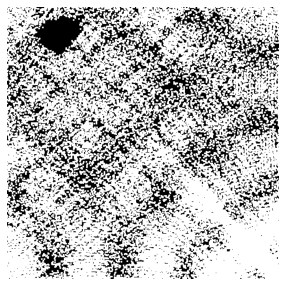

In [8]:
# 5:形态学操作
kernel = np.ones((3, 3), np.uint8)
# 膨胀
img_erosion = cv2.dilate(thresh_basic, kernel, iterations=1)
# img_erosion = cv2.erode(thresh_basic, kernel, iterations=1)

plt.figure(figsize=(5,5))
plt.axis('off')
# plt.title("Dilate")
plt.imshow(img_erosion,cmap=plt.cm.binary_r);

target = img_erosion
print(f'shape={target.shape}\nmax={target.max()}\nmin={target.min()}\nmean={target.mean()}')

dtype=float32
shape=(512, 512)
max=255.0
min=0.0
mean=200.98818969726562


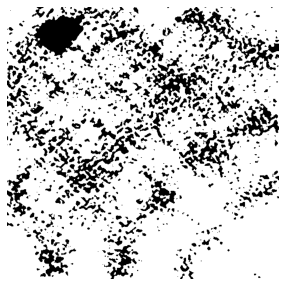

In [9]:
# 6:去除椒盐噪声
img_median = cv2.medianBlur(img_erosion, 5)

plt.figure(figsize=(5,5))
plt.axis('off')
# plt.title("img_median")
plt.imshow(img_median,cmap=plt.cm.binary_r);

target = img_median
print(f'dtype={img_median.dtype}\nshape={target.shape}\nmax={target.max()}\nmin={target.min()}\nmean={target.mean()}')

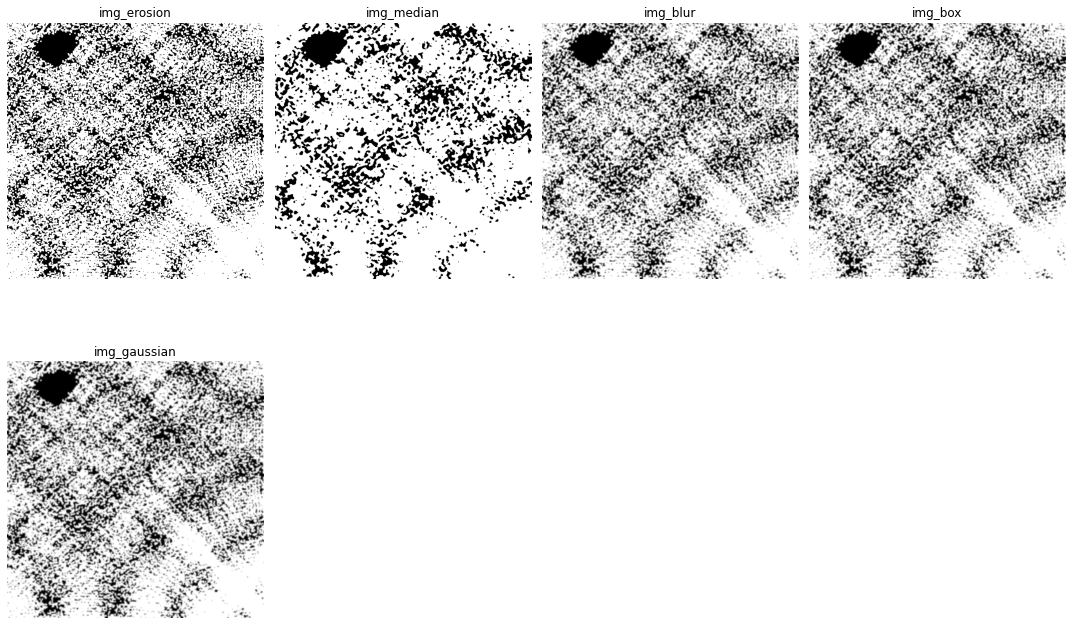

In [10]:
# 滤波器选择
# I:中值滤波器
img_median = cv2.medianBlur(img_erosion, 5)
# II：均值滤波器
img_blur = cv2.blur(img_erosion, (3, 3))
# III：方框滤波器
img_box = cv2.boxFilter(img_erosion,-1,(3,3),normalize=True)
# IV：高斯滤波器
img_gaussian = cv2.GaussianBlur(img_erosion, (5, 5), 1)  

plt.figure(figsize=(15,10))

plt.subplot(241)
plt.imshow(img_erosion,cmap=plt.cm.gray)
plt.title('img_erosion')
plt.axis('off')

plt.subplot(242)
plt.imshow(img_median,cmap=plt.cm.gray)
plt.title('img_median')
plt.axis('off')

plt.subplot(243)
plt.imshow(img_blur,cmap=plt.cm.gray)
plt.title('img_blur')
plt.axis('off')

plt.subplot(244)
plt.imshow(img_box,cmap=plt.cm.gray)
plt.title('img_box')
plt.axis('off')

plt.subplot(245)
plt.imshow(img_gaussian,cmap=plt.cm.gray)
plt.title('img_gaussian')
plt.axis('off')

plt.tight_layout()

shape=(512, 512)
max=255
min=0
mean=25.256423950195312


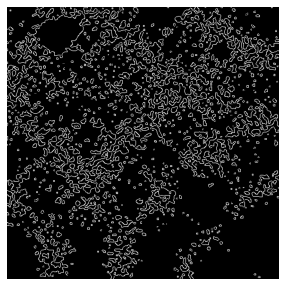

In [11]:
# 7:Canny边缘检测
THRESHOLD1 = 1
THRESHOLD2 = 0

edged = cv2.Canny((img_median*255).astype(np.uint8),THRESHOLD1,THRESHOLD2)

plt.figure(figsize=(5,5))
plt.axis('off')
# plt.title("Canny Edges")
plt.imshow(edged,cmap=plt.cm.binary_r);

print(f'shape={edged.shape}\nmax={edged.max()}\nmin={edged.min()}\nmean={edged.mean()}')

检测到缺陷
检测到11个缺陷
highlighted_img的shape=(512, 512),max=1.0,min=0.0,mean=0.29608994722366333


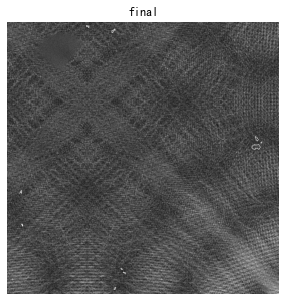

In [12]:
# 8:轮廓
thresh_inv_uint8 = img_median.astype(np.uint8)
contours, h = cv2.findContours(thresh_inv_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# get total contours
num_of_con = str(len(contours) - 1)
imageOri = img.detach().cpu().numpy()[0][0]
# CON_COLOR = (0, 0, 0)
CON_COLOR = (255, 255, 255)
CON_THICKNESS = 1

if len(contours) > 1:
    print("检测到缺陷")
if int(num_of_con) != 0:
    for i in range(int(num_of_con)):
        highlighted_img = cv2.drawContours(imageOri, contours, i, 1, CON_THICKNESS)
    print(f'检测到{num_of_con}个缺陷')
else:
    print("没有检测到缺陷")
    
plt.figure(figsize=(5,5))
plt.axis('off')
plt.rcParams['font.sans-serif']=['SimHei']
# plt.title(f"缺陷数量:{num_of_con}")
plt.title('final')
plt.imshow(highlighted_img,cmap=plt.cm.gray)
# plt.imshow(highlighted_img)

print(f'highlighted_img的shape={highlighted_img.shape},max={highlighted_img.max()},min={highlighted_img.min()},mean={highlighted_img.mean()}')

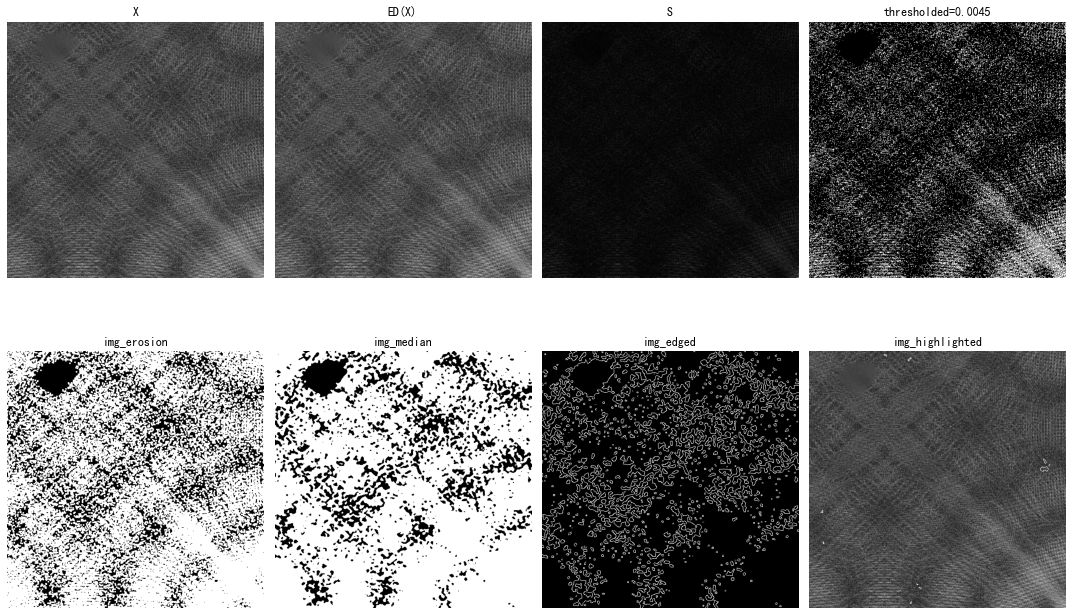

In [13]:
# 总图
plt.figure(figsize=(15,10))

plt.subplot(241);
plt.imshow(img.detach().cpu().numpy()[0][0],cmap=plt.cm.gray);
plt.title('X')
plt.axis('off');

plt.subplot(242);
plt.imshow(y[0][0].detach().cpu().numpy(),cmap=plt.cm.gray);
plt.title('ED(X)')
plt.axis('off');

plt.subplot(243);
plt.imshow(S.detach().cpu().numpy(),cmap=plt.cm.gray);
plt.title('S')
plt.axis('off');

plt.subplot(244);
plt.imshow(thresh_basic,cmap=plt.cm.gray);
plt.title(f'thresholded={THRESHOLD_VALUE}')
plt.axis('off');

plt.subplot(245);
plt.imshow(img_erosion,cmap=plt.cm.gray);
plt.title('img_erosion')
plt.axis('off');

plt.subplot(246);
plt.imshow(img_median,cmap=plt.cm.gray);
plt.title('img_median')
plt.axis('off');

plt.subplot(247);
plt.imshow(edged,cmap=plt.cm.gray);
plt.title('img_edged')
plt.axis('off');

plt.subplot(248);
plt.imshow(highlighted_img,cmap=plt.cm.gray);
plt.title('img_highlighted')
plt.axis('off');

plt.tight_layout()

# plt.savefig('sample_detection.png', bbox_inches='tight')

(-0.5, 511.5, 511.5, -0.5)

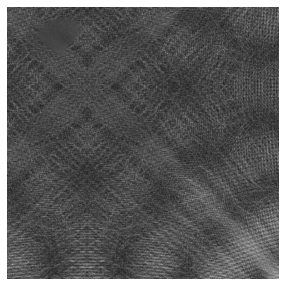

In [14]:
img_original = img.detach().cpu().numpy()[0][0]
img_3 = cv2.cvtColor(img_original, cv2.COLOR_GRAY2BGR)

# 总图
plt.figure(figsize=(5,5))

# plt.subplot(241)
plt.imshow(img_3,cmap=plt.cm.gray)
# plt.title('X')
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


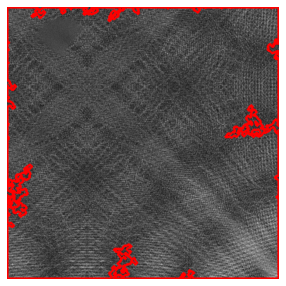

In [15]:
# 8:轮廓
thresh_inv_uint8 = img_median.astype(np.uint8)
contours, h = cv2.findContours(thresh_inv_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# get total contours
num_of_con = str(len(contours) - 1)
imageOri = img_3
# CON_COLOR = (0, 0, 0)
CON_COLOR = (255, 0, 0)
CON_THICKNESS = 3

highlighted_img = cv2.drawContours(imageOri, contours, -1, CON_COLOR, CON_THICKNESS)

plt.figure(figsize=(5,5))
plt.axis('off')
plt.rcParams['font.sans-serif']=['SimHei']
# plt.title(f"缺陷数量:{num_of_con}")
plt.imshow(highlighted_img)